# 📌 Hybrid Recommendation System (Movies & Anime)

## **Unsupervised Clustering & Content-Based Approach**  

This project aims to build a **movie & anime recommendation system** using **unsupervised machine learning (clustering) and content-based filtering**.  


**Key Objectives:**  

- Cluster Netflix movies & anime based on features  
- Use content similarity to recommend relevant titles  
- Explore data to understand key patterns and trends  


### 📖 Notebook Overview  


This notebook focuses on **loading and exploring the dataset** to understand its structure, quality, and key characteristics.  


**What we are doing:**  

✔ Loading Netflix and anime datasets 
✔ Performing an initial inspection (shape, columns, missing values)  
✔ Generating summary statistics and sample data  

**Why we are doing this:**  

Understanding the dataset is crucial before feature engineering and modeling. We need to ensure data consistency and identify potential issues like missing values or incorrect formats.  

**What we expect:**  

By the end of this notebook, we should have:

✔ A clear understanding of dataset structure
✔ Insights into missing or inconsistent data  
✔ A plan for preprocessing steps  


## 🛠 **Importing Libraries & Loading Data**

In [1]:
import sys
import os

In [2]:
# Get absolute path to the project's root directory
project_root = os.path.abspath("..")

# Add project root to sys.path (so src/ and utils/ are accessible)
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [4]:
from utils.config import MOVIES_PATH, ANIME_PATH
from utils.visualization import visualize_chart, plot_functions

from summaries.register_summaries import summary_factory

from src.data_preprocessing.data_analysis import analyze_dataset 
from src.data_preprocessing.create_dataframe import create_dataframe
from src.data_preprocessing.cleaning import clean_text
from src.data_preprocessing.parse_json import parse_json_column

from src.eda.correlation.analyze_correlation import analyze_correlation_matrix
from src.eda.skewness.analyze_skewness import analyze_skewness
from src.eda.outliers.transformations import best_transformation_with_outliers

from src.feature_engineering.combine_text import create_combined_text
from src.feature_engineering.numeric_features import combine_text_and_numeric
from src.feature_engineering.vectorization import build_tfidf_matrix, build_count_matrix

from src.modeling.clustering import fit_kmeans, cluster_recommender
from src.modeling.content_based import build_user_vector, recommend_items

In [5]:
# nltk.download('stopwords')

In [6]:
# pandas additional settings
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_column', None)
pd.set_option('display.width', None)

# nltk stop words settings
stop_words = set(stopwords.words('english'))


### Functions 

In [7]:
def hybrid_recommender_kmeans(
    user_text: str = "",
    user_numeric_movies: dict = None,
    user_numeric_anime: dict = None,
    top_movies: int = 5,
    top_anime: int = 5
):
    """
    1) Build user vector for movies and anime.
    2) Find the closest cluster for each domain by comparing user vector to cluster centroids.
    3) Get the items from that cluster, re-rank them by content similarity (or popularity).
    4) Return top_k for movies and anime.

    Requirements:
      - kmeans_movies, kmeans_anime: Fitted KMeans models with .cluster_centers_
      - movies_df, anime_df: Each has a 'cluster_label' column.
      - mv_vectorizer, an_vectorizer, mv_scaler, an_scaler: same objects used to build your combined matrices.
      - mv_combined_matrix, an_combined_matrix: final (text+numeric) matrices for each domain.
    """
    if user_numeric_movies is None:
        user_numeric_movies = {}
    if user_numeric_anime is None:
        user_numeric_anime = {}

    # 1) Build user vectors (text+numeric) for movies and anime
    mv_uv = build_user_vector(
        user_text=user_text,
        vectorizer=mv_vectorizer,
        numeric_values=user_numeric_movies,
        numeric_cols=numeric_cols_movies,  # EXACT same columns used in combine_text_and_numeric
        scaler=mv_scaler
    )
    an_uv = build_user_vector(
        user_text=user_text,
        vectorizer=an_vectorizer,
        numeric_values=user_numeric_anime,
        numeric_cols=numeric_cols_anime,   # EXACT same columns used for anime
        scaler=an_scaler
    )

    # 2) Find closest cluster (movies)
    #    Compare user vector to each cluster center -> pick cluster with highest similarity or min distance
    mv_centroids = kmeans_movies.cluster_centers_  # shape: (n_clusters, n_features)
    mv_sim = cosine_similarity(mv_uv, mv_centroids).flatten()
    # cluster_id is the centroid most similar to user
    mv_cluster_id = np.argmax(mv_sim)

    # 3) Filter movies in that cluster
    cluster_movies = movies_df1[movies_df1['cluster_label'] == mv_cluster_id]

    # 4) Optionally re-rank these cluster items by content similarity with user vector
    #    We can slice out only that cluster's rows from the combined matrix, compute sim, pick top_k
    cluster_indices = cluster_movies.index
    cluster_matrix = mv_combined_matrix[cluster_indices]  # sub-matrix

    sim_scores = cosine_similarity(mv_uv, cluster_matrix).flatten()
    sorted_idx = np.argsort(sim_scores)[::-1][:top_movies]
    recommended_mv_indices = cluster_indices[sorted_idx]
    recommended_movies = movies_df.loc[recommended_mv_indices, 'title'].values

    # ------------------------------------------------------------------------
    # Repeat for anime
    an_centroids = kmeans_anime.cluster_centers_
    an_sim = cosine_similarity(an_uv, an_centroids).flatten()
    an_cluster_id = np.argmax(an_sim)
    cluster_anime = anime_df1[anime_df1['cluster_label'] == an_cluster_id]

    cluster_indices_an = cluster_anime.index
    cluster_matrix_an = an_combined_matrix[cluster_indices_an]

    sim_scores_an = cosine_similarity(an_uv, cluster_matrix_an).flatten()
    sorted_idx_an = np.argsort(sim_scores_an)[::-1][:top_anime]
    recommended_an_indices = cluster_indices_an[sorted_idx_an]
    recommended_anime = anime_df.loc[recommended_an_indices, 'title'].values

    return recommended_movies, recommended_anime


In [8]:
def find_optimal_clusters(matrix, min_k=2, max_k=15, random_state=42, n_init=10):
    """
    Find the optimal number of clusters for K-Means using the silhouette score.

    Parameters:
    -----------
    matrix : array-like or sparse matrix, shape (n_samples, n_features)
        The feature matrix on which clustering is performed (e.g., TF-IDF or combined matrix).
    min_k : int, default=2
        Minimum number of clusters to try.
    max_k : int, default=15
        Maximum number of clusters to try.
    random_state : int, default=42
        Random state for reproducibility.
    n_init : int, default=10
        Number of time the k-means algorithm will be run with different centroid seeds.
    
    Returns:
    --------
    best_k : int
        The optimal number of clusters based on the highest silhouette score.
    metrics : dict
        Dictionary where keys are cluster numbers and values are another dictionary with:
           - "silhouette_score": float
           - "inertia": float
    """
    metrics = {}
    best_k = None
    best_score = -1  # silhouette score ranges from -1 to 1

    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = kmeans.fit_predict(matrix)
        sil_score = silhouette_score(matrix, labels)
        inertia = kmeans.inertia_
        metrics[k] = {"silhouette_score": sil_score, "inertia": inertia}
        if sil_score > best_score:
            best_score = sil_score
            best_k = k
    return best_k, metrics


In [9]:
def visualize_clusters_with_pca(matrix, labels, random_state=42, sample_frac=1.0):
    """
    Reduces the feature matrix to 2 dimensions using PCA and returns a scatter plot.
    
    Parameters:
    -----------
    matrix : array-like or sparse matrix, shape (n_samples, n_features)
        The feature matrix (e.g., TF-IDF or combined text+numeric matrix).
    labels : array-like, shape (n_samples,)
        Cluster labels for each sample.
    random_state : int, default=42
        Random state for reproducibility.
    sample_frac : float, default=1.0
        Fraction of data to sample for plotting. Use less than 1.0 if the dataset is large.
        
    Returns:
    --------
    reduced : np.ndarray, shape (n_samples_sampled, 2)
        The 2D PCA-transformed data.
    explained_variance_ratio : np.ndarray, shape (2,)
        The percentage of variance explained by each of the selected components.
    """
    n_samples = matrix.shape[0]
    indices = np.arange(n_samples)
    if sample_frac < 1.0:
        np.random.seed(random_state)
        np.random.shuffle(indices)
        keep_count = int(sample_frac * n_samples)
        indices = indices[:keep_count]
        matrix_sample = matrix[indices]
        labels_sample = np.array(labels)[indices]
    else:
        matrix_sample = matrix
        labels_sample = np.array(labels)

    # If the matrix is sparse, convert to dense (or consider using TruncatedSVD for huge matrices)
    if hasattr(matrix_sample, "toarray"):
        X = matrix_sample.toarray()
    else:
        X = matrix_sample

    pca = PCA(n_components=2, random_state=random_state)
    reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels_sample, cmap="viridis", alpha=0.7)
    plt.title("PCA Visualization of Clusters")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Cluster Label")
    plt.show()
    
    return reduced, pca.explained_variance_ratio_

In [10]:
def get_elbow_chart_obj(matrix, max_clusters=10, random_state=42):
    """
    Plots the 'elbow' by fitting KMeans from k=1..max_clusters
    and recording the inertia_ (sum of squared distances to centroids).
    """
    inertia_vals = []
    ks = range(1, max_clusters + 1)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        km.fit(matrix)
        inertia_vals.append(km.inertia_)

    chart_obj = [{
        "plot_function": plot_functions["line"],
        "title": "Elbow Plot for K-Means",
        "xlabel": "Number of Clusters (k)",
        "ylabel": "Inertia (SSE)",
        "x": ks,
        "y": inertia_vals
    }]
    return chart_obj


## Data Preprocessing

In [11]:
# Load datasets
movies_df = create_dataframe(MOVIES_PATH)
anime_df = create_dataframe(ANIME_PATH)

### First Look - Movies

In [12]:
result = analyze_dataset(movies_df, exclude_columns=['id'])

In [13]:
print(summary_factory.generate_summary("overview", result))
print("\n" + "="*80 + "\n")
print(summary_factory.generate_summary("observations", result))

The dataset contains 4803 rows and 20 columns.

There are 3941 missing values across 5 columns.
Missing values account for 4.10% of the dataset.
Columns with missing values and their counts:
  - homepage: 3091 missing values
  - overview: 3 missing values
  - release_date: 1 missing values
  - runtime: 2 missing values
  - tagline: 844 missing values

There are no duplicate rows in the dataset.

Data Types:

              Column DataType
              budget    int64
              genres   object
            homepage   object
                  id    int64
            keywords   object
   original_language   object
      original_title   object
            overview   object
          popularity  float64
production_companies   object
production_countries   object
        release_date   object
             revenue    int64
             runtime  float64
    spoken_languages   object
              status   object
             tagline   object
               title   object
        vote_avera

### Handling Missing Values

The dataset contains 4803 rows and 20 columns.

There are 3941 missing values across 5 columns.

  - homepage: 3091 missing values (64.35561107641058% of data is missing)
  - overview: 3 missing values - 
  - release_date: 1 missing values
  - runtime: 2 missing values
  - tagline: 844 missing values

In [14]:
movies_df[movies_df['release_date'].isna()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4553,0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.00,[],[],NaN,0,0.00,[],Released,NaN,America Is Still the Place,0.00,0


In [15]:
movies_df = movies_df.dropna(subset=['release_date'])

In [16]:
movies_df[movies_df['overview'].isna()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.74,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.30,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.05,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.00,0
4431,913000,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,292539,[],de,Food Chains,NaN,0.80,[],[],2014-04-26,0,83.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Food Chains,7.40,8


In [17]:
movies_df[movies_df['runtime'].isna()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.74,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.30,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.05,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.00,0


In [18]:
# excluding non-numeric and columns that are not needed in descriptive summary function like df.describe(), correlation and skewness etc

exclude_columns = {'id', 'vote_average', ''}

In [19]:
movies_df.drop(columns=['homepage'], inplace=True)

In [20]:
movies_df['tagline'].fillna('no tagline', inplace=True)

In [21]:
movies_df.loc[2656, 'overview'] = "On his path to becoming Pope Francis, Father Jorge Bergoglio pursues his religious vocation in a country ravaged by a brutal military dictatorship."
movies_df.loc[4140, 'overview'] = "An exploration of how singer and actor Frank Sinatra became one of the biggest stars of the 20th century while remaining, in his heart, a normal person."
movies_df.loc[4431, 'overview'] = "In America, farm labor has always been one of the most difficult, poorly paid jobs and has relied on some of the nation's most vulnerable people. While the legal restrictions that keep people bound to farms have been abolished, exploitation still exists. Ranging from wage theft to modern-day slavery, this exploitation is perpetuated by the corporations at the top of the food chain: supermarkets."

In [22]:
movies_df.loc[2656, 'runtime'] = 113
movies_df.loc[4140, 'runtime'] = 81

In [23]:
# Convert release_date to datetime and extract year
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')

In [24]:
movies_df['release_year'] = movies_df['release_date'].dt.year

In [25]:

# Convert budget and revenue to millions for better readability
movies_df['budget_million'] = movies_df['budget'] / 1e6
movies_df['revenue_million'] = movies_df['revenue'] / 1e6


In [26]:
def process_list_columns(column):
    return movies_df[column].fillna('[]').apply(lambda x: [item['name'] for item in eval(x)] if isinstance(x, str) and x.startswith('[') else [])

In [27]:
list_columns = ['genres', 'keywords', 'production_companies', 'production_countries']

In [28]:
# for col in list_columns:
#     movies_df[col] = process_list_columns(col)

## Exploratory Data Analysis

In [29]:
filter_column = list(set(movies_df.columns) - exclude_columns)

### Correlation

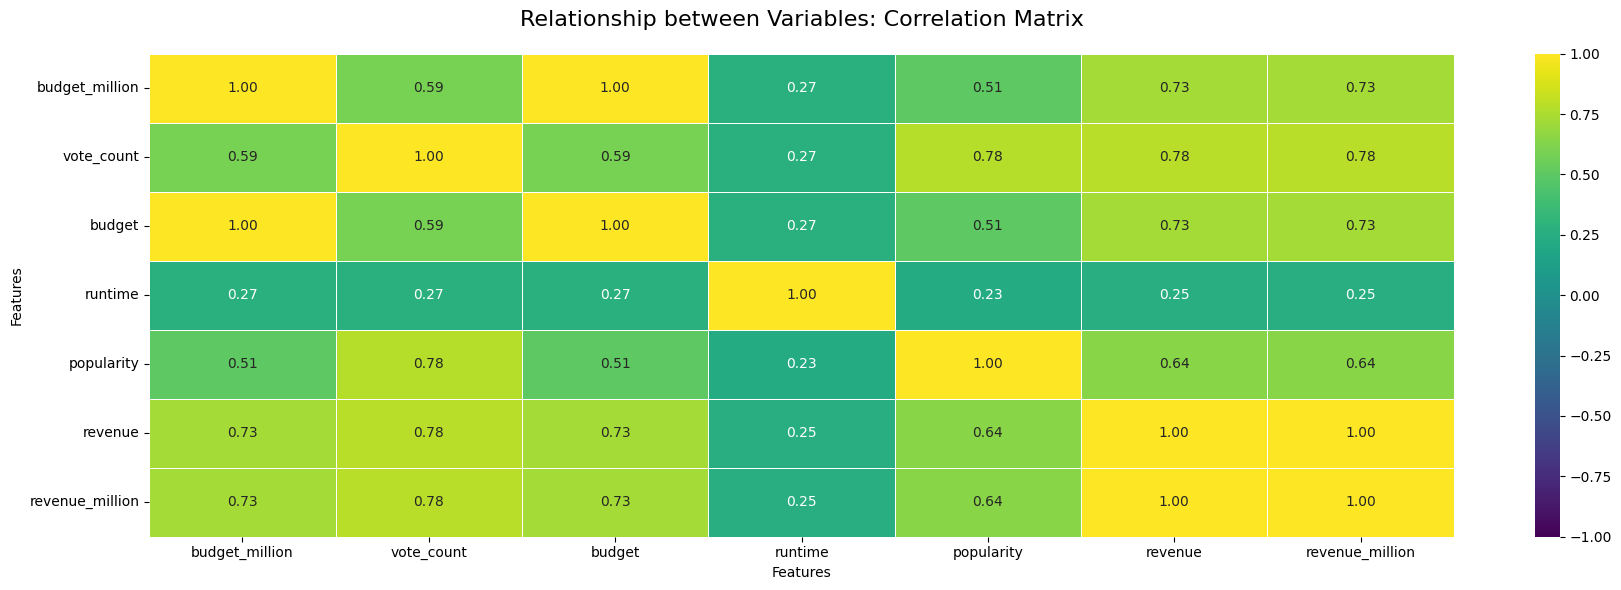

In [30]:
result = analyze_correlation_matrix(movies_df, filter_column)

### Skewness

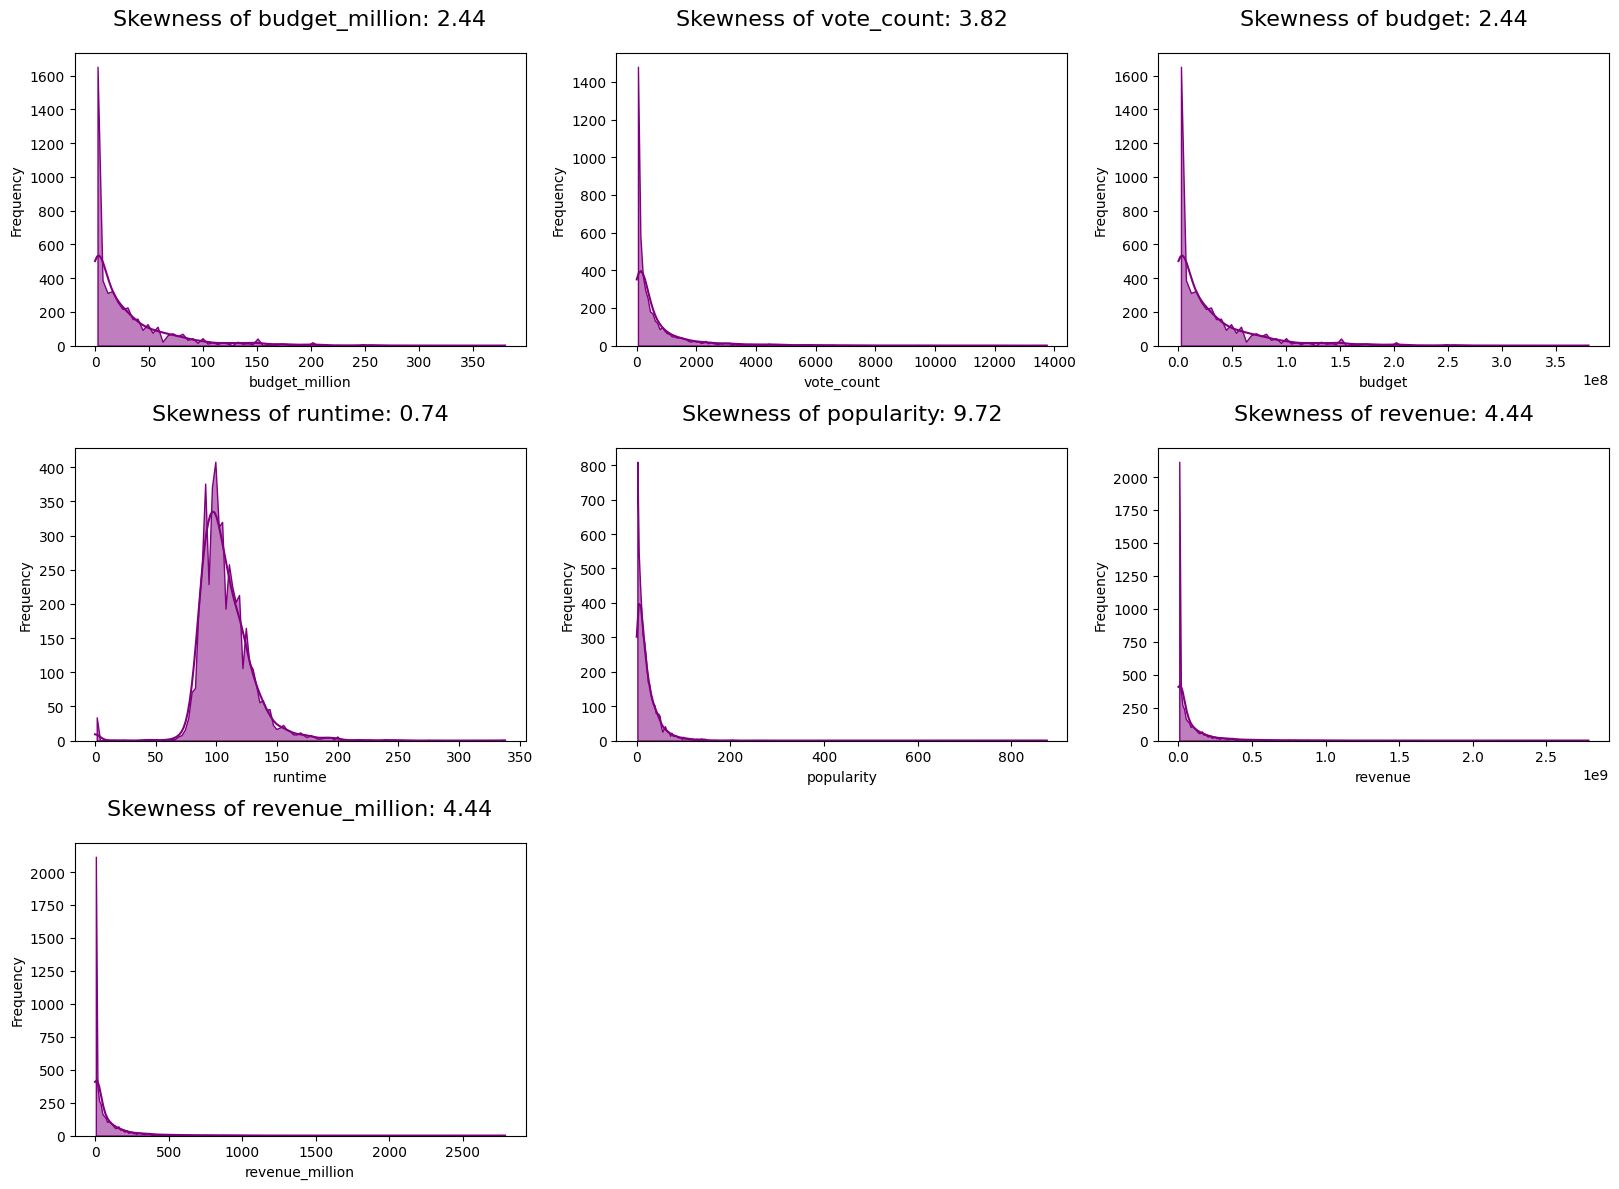

In [31]:
skewness = analyze_skewness(movies_df, filter_column)

In [32]:
print(summary_factory.generate_summary("skewness", skewness))

- Highly skewed columns (suggesting log transformation): budget_million, vote_count, budget, popularity, revenue, revenue_million
- Moderately skewed columns (suggesting square root transformation): runtime

Detailed Skewness Values:
         Column  Skewness
 budget_million      2.44
     vote_count      3.82
         budget      2.44
        runtime      0.74
     popularity      9.72
        revenue      4.44
revenue_million      4.44


### Outliers

In [33]:
# Chart_objs to create subpots - boxplot for each columns

chart_objs = []
for col in filter_column:
    # print(col, skewness[col])
    if movies_df[col].dtypes in ['int64', 'float64']:
        print(col)
        chart_objs.append({
        'plot_function':plot_functions['box'] ,
        'title': f'Boxplot of {col}',  # Title for each individual column
        'xlabel': col,
        'ylabel': None,
        'x': movies_df[col],
        'kwargs': { 'color': 'purple'}
        })

budget_million
vote_count
budget
runtime
popularity
revenue
revenue_million


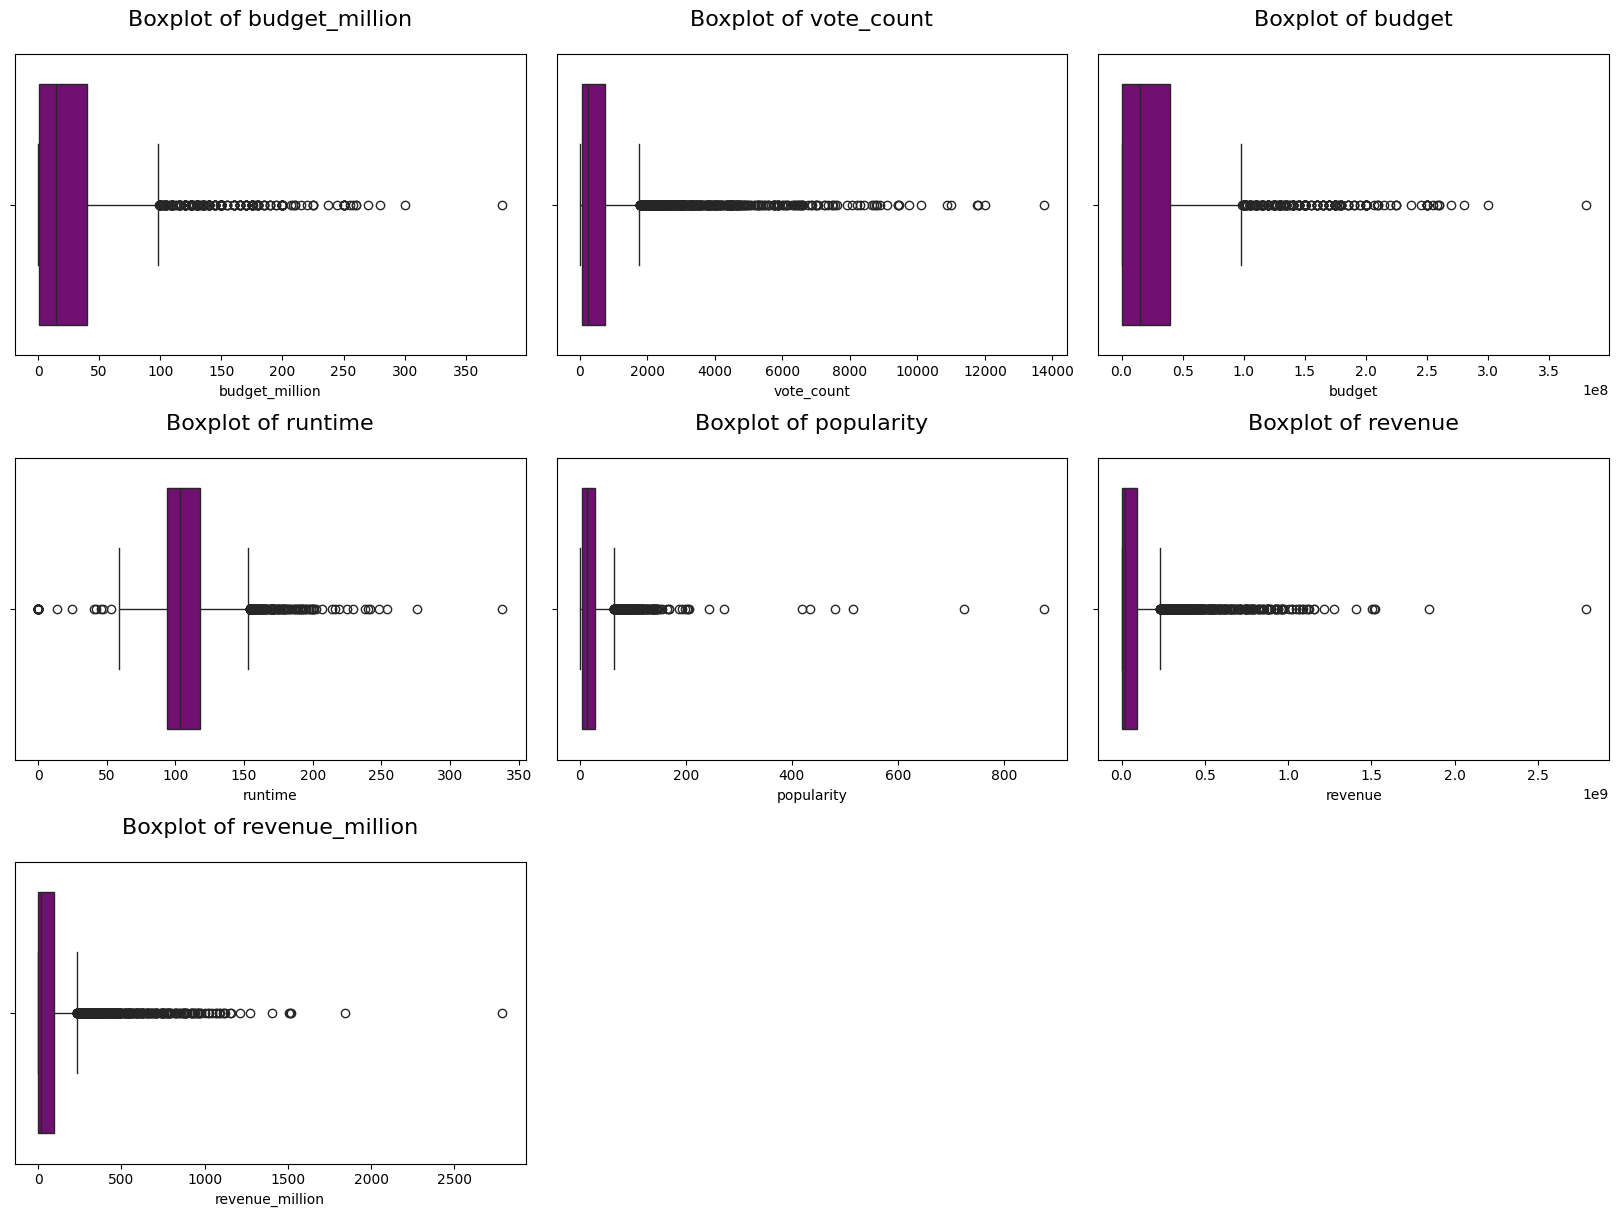

In [34]:
# Fig - Visualizing the box plots for each numeric columns 

visualize_chart(chart_objs, nrows=(len(filter_column) // 3 + 1), ncols=3)
plt.show()

In [35]:
# Transforming data using (log , sqrt) transformations and separating df and outliers in separate dataframe
movies_df1 = best_transformation_with_outliers(movies_df, skewness, handle_outliers=False)

Applying log transformation to budget_million due to high_skew skewness.
Applying log transformation to vote_count due to high_skew skewness.
Applying log transformation to budget due to high_skew skewness.
Applying log transformation to popularity due to high_skew skewness.
Applying log transformation to revenue due to high_skew skewness.
Applying log transformation to revenue_million due to high_skew skewness.
Applying sqrt transformation to runtime due to moderate_skew skewness.


In [36]:
movies_df1.sample().copy()

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,release_year,budget_million,revenue_million
2578,16.81,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",8975,"[{""id"": 3149, ""name"": ""gangster boss""}, {""id"":...",en,The Marine,A group of diamond thieves on the run kidnap t...,2.16,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-10-13,16.91,9.59,"[{""iso_639_1"": ""ar"", ""name"": ""\u0627\u0644\u06...",Released,War is Fine But The Fight Continues,The Marine,5.00,5.10,2006,3.04,3.14


In [37]:
movies_df1[['genres']].iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [38]:
json_cols_movies = ["genres", "keywords"]
text_cols_movies = ["overview", "tagline", "keywords"]  # Overlapping 'keywords' is okay; your call

In [39]:
movies_df1 = movies_df1.reset_index(drop=True)

In [40]:
create_combined_text(
    df=movies_df1,
    json_cols=json_cols_movies,
    text_cols=text_cols_movies,
    combined_col="combined_text",
    json_key="name"
)

In [41]:
mv_vectorizer, mv_text_matrix = build_tfidf_matrix(
    df=movies_df1,
    text_col="combined_text"
)

In [42]:
numeric_cols_movies = ["budget", "revenue", "popularity"]  # or your chosen columns

In [43]:
mv_combined_matrix, mv_scaler = combine_text_and_numeric(
    movies_df1,
    mv_text_matrix,
    numeric_cols=numeric_cols_movies,
    scaler=None
)

**!TEST!**

In [44]:
user_text_movies = "adventure action thrill"
user_numeric_movies = {
    "budget": 20_000_000,     # Example budget preference
    "revenue": 100_000_000,   # Example revenue preference
    "popularity": 50          # Example popularity preference
}

In [45]:
mv_user_vector = build_user_vector(
    user_text=user_text_movies,
    vectorizer=mv_vectorizer,
    numeric_values=user_numeric_movies,
    numeric_cols=numeric_cols_movies,
    scaler=mv_scaler
)

In [46]:
recommended_movie_titles = recommend_items(
    df=movies_df1,
    combined_matrix=mv_combined_matrix,
    user_vector=mv_user_vector,
    top_k=5,
    title_col="title",               # Adjust if your column is named differently
    fallback_col="popularity",       # Could be "vote_count" or "popularity"
    already_watched={2, 5, 100}      # Just an example set of row indices
)

list(recommended_movie_titles)

['Fast Five',
 'Transformers: Revenge of the Fallen',
 'The Wolverine',
 'Crocodile Dundee',
 'Fatal Attraction']

In [47]:
best_k, cluster_metrics = find_optimal_clusters(mv_combined_matrix, min_k=2, max_k=15)

In [48]:
print("Optimal number of clusters:", best_k)
print("Cluster metrics:")

for k, metrics in cluster_metrics.items():
    metrics_str = ", ".join(f"{key} = {value:.4f}" for key, value in metrics.items())
    print(f"{k}: {metrics_str}")

Optimal number of clusters: 2
Cluster metrics:
2: silhouette_score = 0.4318, inertia = 10100.6781
3: silhouette_score = 0.3331, inertia = 8199.3869
4: silhouette_score = 0.2409, inertia = 7028.2652
5: silhouette_score = 0.2148, inertia = 6500.5654
6: silhouette_score = 0.1615, inertia = 6108.5397
7: silhouette_score = 0.1643, inertia = 5735.3098
8: silhouette_score = 0.1514, inertia = 5534.3027
9: silhouette_score = 0.1246, inertia = 5380.3388
10: silhouette_score = 0.1109, inertia = 5293.7233
11: silhouette_score = 0.0920, inertia = 5217.1339
12: silhouette_score = 0.0837, inertia = 5161.2202
13: silhouette_score = 0.0768, inertia = 5124.6689
14: silhouette_score = 0.0725, inertia = 5054.9484
15: silhouette_score = 0.0659, inertia = 5019.1145


In [49]:
kmeans_movies = KMeans(n_clusters=best_k, random_state=42, n_init=10)
mv_labels = kmeans_movies.fit_predict(mv_combined_matrix)
movies_df1["cluster_label"] = mv_labels

In [50]:
target_movie = "Avatar"  # Must match exactly a title in movies_df
cluster_suggestions = cluster_recommender(
    df=movies_df1,
    labels=mv_labels,
    target_item=target_movie,
    title_col="title",
    label_col="cluster_label",
    top_k=5
)

In [51]:
cluster_suggestions

array(["Pirates of the Caribbean: At World's End", 'Spectre',
       'The Dark Knight Rises', 'John Carter', 'Spider-Man 3'],
      dtype=object)

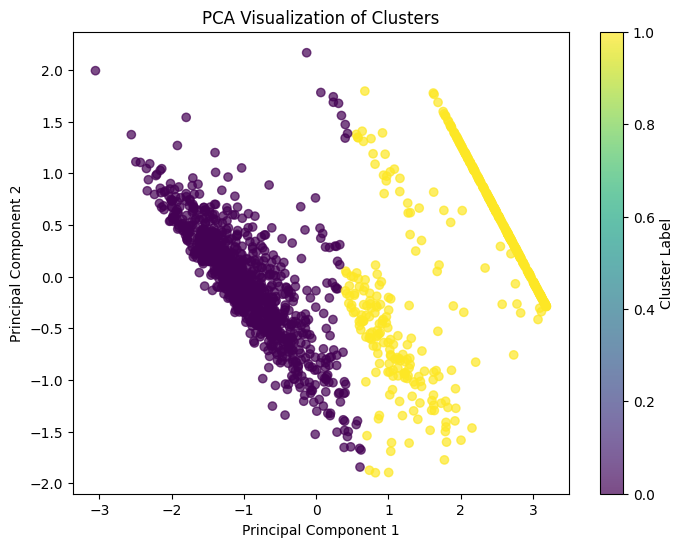

Explained Variance Ratio (PC1, PC2): [0.58587974 0.10371767]


In [52]:
reduced_data, var_ratio = visualize_clusters_with_pca(mv_combined_matrix, mv_labels, sample_frac=0.3)
print("Explained Variance Ratio (PC1, PC2):", var_ratio)


### First Look - Anime

In [53]:
result = analyze_dataset(anime_df, exclude_columns=['anime_id'])

In [54]:
print(summary_factory.generate_summary("overview", result))
print("\n" + "="*80 + "\n")
print(summary_factory.generate_summary("observations", result))

The dataset contains 6668 rows and 33 columns.

There are 25258 missing values across 12 columns.
Missing values account for 11.48% of the dataset.
Columns with missing values and their counts:
  - title_english: 3230 missing values
  - title_japanese: 5 missing values
  - title_synonyms: 2187 missing values
  - image_url: 2 missing values
  - rating: 82 missing values
  - rank: 356 missing values
  - background: 5855 missing values
  - premiered: 3702 missing values
  - broadcast: 3688 missing values
  - producer: 2266 missing values
  - licensor: 3881 missing values
  - genre: 4 missing values

There are no duplicate rows in the dataset.

Data Types:

         Column DataType
       anime_id    int64
          title   object
  title_english   object
 title_japanese   object
 title_synonyms   object
      image_url   object
           type   object
         source   object
       episodes    int64
         status   object
         airing     bool
   aired_string   object
          air

### Handling Missing Values

Columns with missing values and their counts:
  - title_english: 3230 missing values
  - title_japanese: 5 missing values
  - title_synonyms: 2187 missing values
  - image_url: 2 missing values
  - rating: 82 missing values
  - rank: 356 missing values
  - background: 5855 missing values
  - premiered: 3702 missing values
  - broadcast: 3688 missing values
  - producer: 2266 missing values
  - licensor: 3881 missing values
  - genre: 4 missing values

In [55]:
anime_df["image_url"] = anime_df["image_url"].str.replace(
    "https://myanimelist.cdn-dena.com/", "https://myanimelist.net/", regex=False
)

In [56]:
# Drop 'background' because ~87.8% of values are missing
anime_df.drop(columns=['background'], inplace=True)

In [57]:

# Fill textual columns with 'unknown'
anime_df['title_english'].fillna('unknown', inplace=True)
anime_df['title_japanese'].fillna('unknown', inplace=True)
anime_df['title_synonyms'].fillna('unknown', inplace=True)
anime_df['image_url'].fillna('unknown', inplace=True)
anime_df['rating'].fillna('unknown', inplace=True)
anime_df['premiered'].fillna('unknown', inplace=True)
anime_df['broadcast'].fillna('unknown', inplace=True)
anime_df['producer'].fillna('unknown', inplace=True)
anime_df['licensor'].fillna('unknown', inplace=True)
anime_df['genre'].fillna('unknown', inplace=True)

In [58]:
# Fill numeric 'rank' with -1 to indicate missing
anime_df['rank'].fillna(-1, inplace=True)


In [59]:
# excluding non-numeric and columns that are not needed in descriptive summary function like df.describe(), correlation and skewness etc
exclude_columns = {'anime_id', }

## Exploratory Data Analysis

In [60]:
filter_column = list(set(anime_df.columns) - exclude_columns)

### Correlation

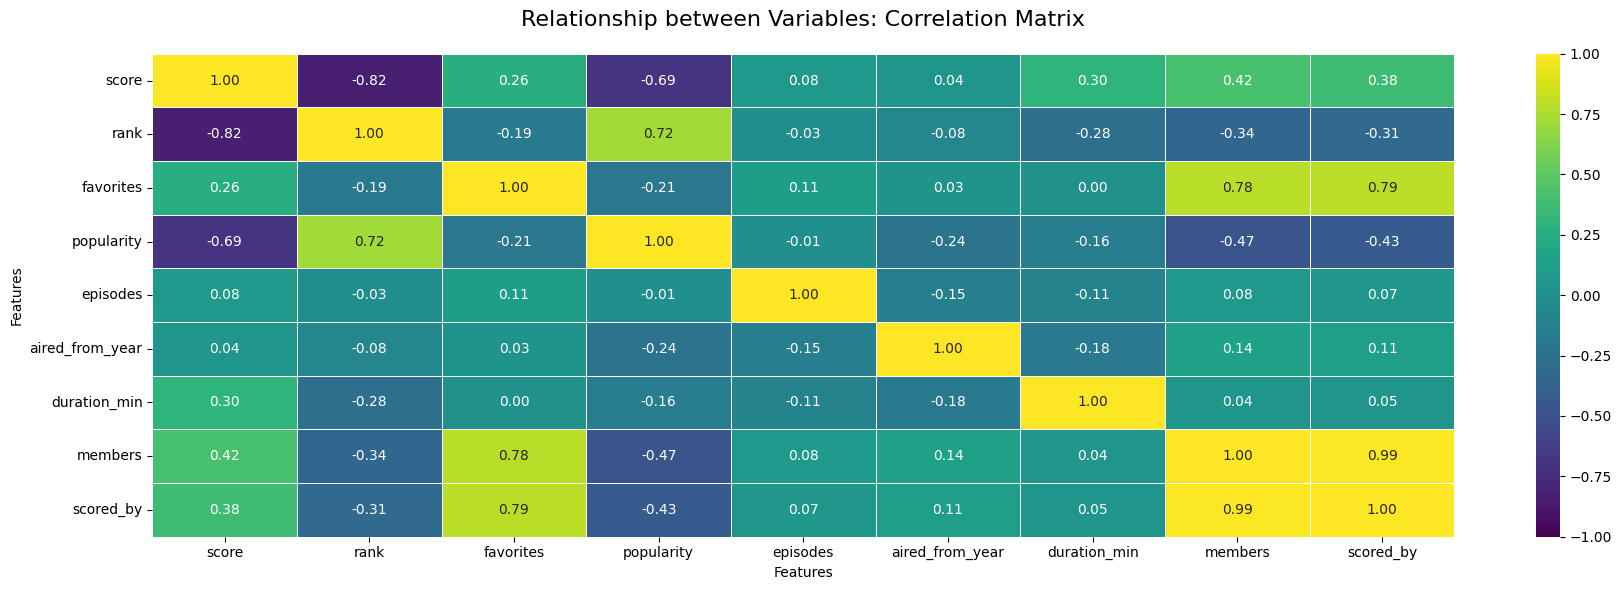

In [61]:
result = analyze_correlation_matrix(anime_df, filter_column)

### Skewness

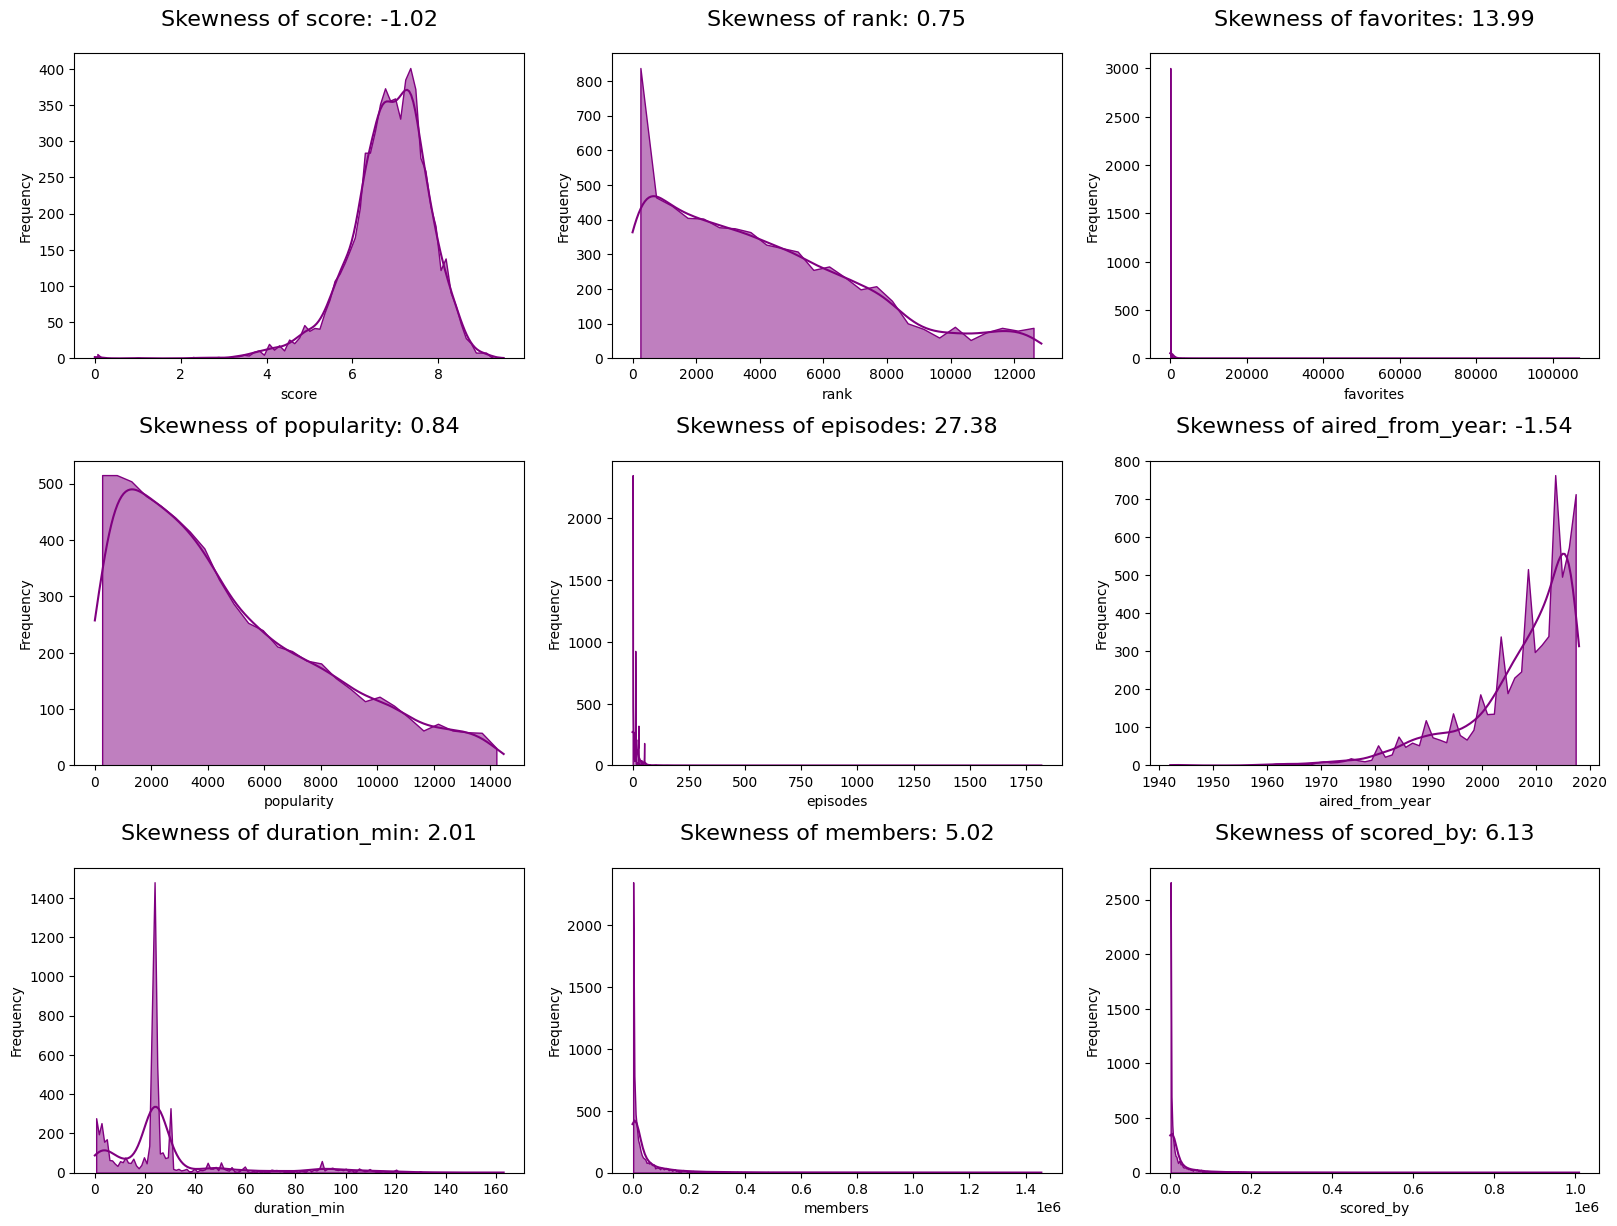

In [62]:
skewness = analyze_skewness(anime_df, filter_column)

In [63]:
print(summary_factory.generate_summary("skewness", skewness))

- Highly skewed columns (suggesting log transformation): score, favorites, episodes, aired_from_year, duration_min, members, scored_by
- Moderately skewed columns (suggesting square root transformation): rank, popularity

Detailed Skewness Values:
         Column  Skewness
          score     -1.02
           rank      0.75
      favorites     13.99
     popularity      0.84
       episodes     27.38
aired_from_year     -1.54
   duration_min      2.01
        members      5.02
      scored_by      6.13


### Outliers

In [64]:
# Chart_objs to create subpots - boxplot for each columns

chart_objs = []
for col in filter_column:
    # print(col, skewness[col])
    if anime_df[col].dtypes in ['int64', 'float64']:
        print(col)
        chart_objs.append({
        'plot_function':plot_functions['box'] ,
        'title': f'Boxplot of {col}',  # Title for each individual column
        'xlabel': col,
        'ylabel': None,
        'x': anime_df[col],
        'kwargs': { 'color': 'purple'}
        })

score
rank
favorites
popularity
episodes
aired_from_year
duration_min
members
scored_by


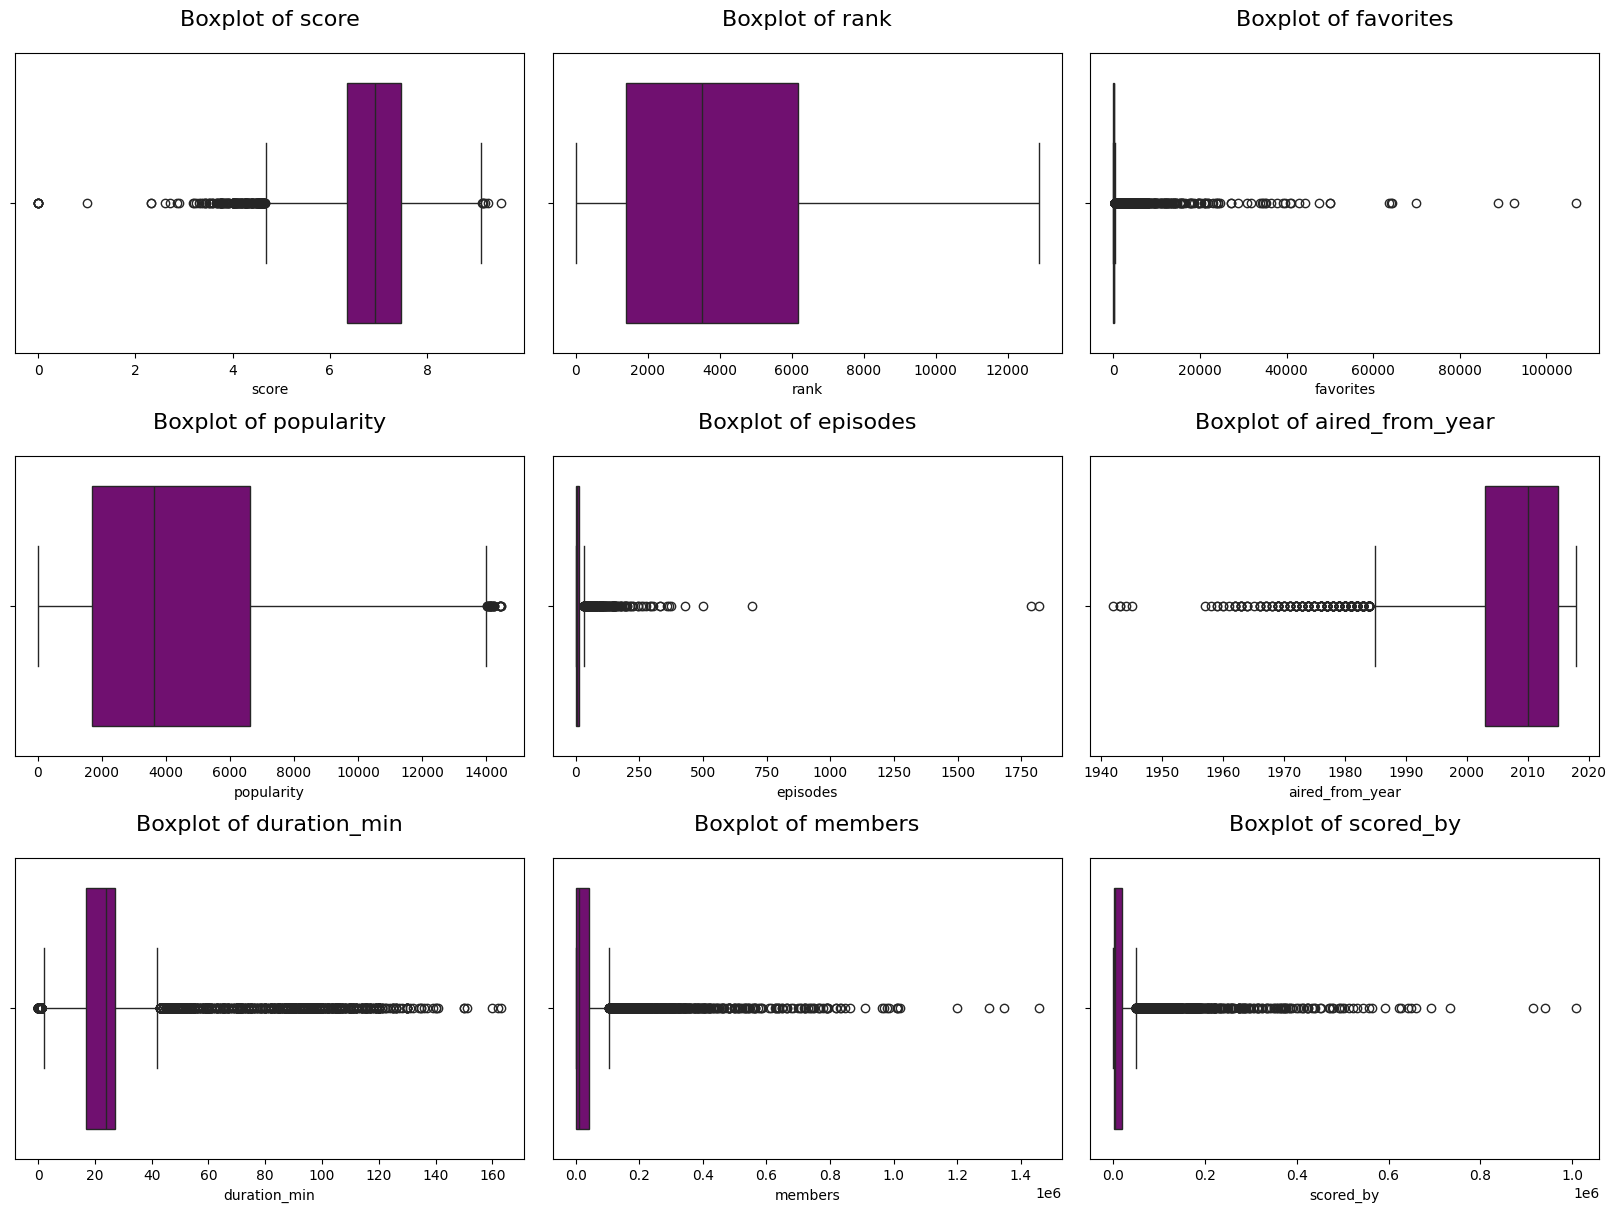

In [65]:
# Fig - Visualizing the box plots for each numeric columns 

visualize_chart(chart_objs, nrows=(len(filter_column) // 3 + 1), ncols=3)
plt.show()

In [66]:
anime_df1 = best_transformation_with_outliers(anime_df, skewness, handle_outliers=False)

Applying log transformation to score due to high_skew skewness.
Applying log transformation to favorites due to high_skew skewness.
Applying log transformation to episodes due to high_skew skewness.
Applying log transformation to aired_from_year due to high_skew skewness.
Applying log transformation to duration_min due to high_skew skewness.
Applying log transformation to members due to high_skew skewness.
Applying log transformation to scored_by due to high_skew skewness.
Applying sqrt transformation to rank due to moderate_skew skewness.
Applying sqrt transformation to popularity due to moderate_skew skewness.


In [67]:
anime_df1.sample()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
1208,31174,Osomatsu-san,Mr. Osomatsu,おそ松さん,unknown,https://myanimelist.net/images/anime/7/76540.jpg,TV,Manga,3.26,Finished Airing,False,"Oct 6, 2015 to Mar 29, 2016","{'from': '2015-10-06', 'to': '2016-03-29'}",23 min. per ep.,R - 17+ (violence & profanity),2.22,10.45,18.36,29.78,11.49,8.06,Fall 2015,Tuesdays at 01:35 (JST),"{'Adaptation': [{'mal_id': 95212, 'type': 'man...","TV Tokyo, Dentsu, Rakuonsha, Avex Pictures, Da...",Viz Media,Studio Pierrot,"Comedy, Parody","['#1: ""Hanamaru Pippi wa Yoiko dake (はなまるぴっぴはよ...","['#1: ""SIX SAME FACES ~Konya wa Saikou!!!!!!~ ...",3.18,7.61


In [68]:
json_cols_anime = ["genre", "related"]
text_cols_anime = ["title_synonyms", "title_english", "title_japanese", "producer", "licensor"]

In [69]:
anime_df1 = anime_df1.reset_index(drop=True)

In [70]:
create_combined_text(
    df=anime_df1,
    json_cols=json_cols_anime,
    text_cols=text_cols_anime,
    combined_col="combined_text",
    json_key="name"
)

In [71]:
an_vectorizer, an_text_matrix = build_tfidf_matrix(
    df=anime_df1,
    text_col="combined_text"
)

In [72]:
numeric_cols_anime = ["favorites", "members", "popularity"]

In [73]:
an_combined_matrix, an_scaler = combine_text_and_numeric(
    anime_df1,
    an_text_matrix,
    numeric_cols=numeric_cols_anime,
    scaler=None
)

In [74]:
user_text_anime = "adventure action"

In [75]:
an_user_vector = build_user_vector(
    user_text=user_text_anime,
    vectorizer=an_vectorizer,
    numeric_cols=numeric_cols_anime,
    scaler=an_scaler
)

In [76]:
recommended_anime_titles = recommend_items(
    df=anime_df1,
    combined_matrix=an_combined_matrix,
    user_vector=an_user_vector,
    top_k=5,
    title_col="title",               # Adjust if your column is named differently
    fallback_col="popularity",       # Could be "vote_count" or "popularity"
    already_watched={2, 5, 100}      # Just an example set of row indices
)

list(recommended_anime_titles)

['Chikyuu to no Yakusoku',
 'Watashitachi no Mirai',
 'Ongeki',
 'Gum Shaara',
 'A Tang Qi Yu']

In [77]:
best_k, cluster_metrics = find_optimal_clusters(an_combined_matrix, min_k=2, max_k=15)

In [78]:
print("Optimal number of clusters:", best_k)
print("Cluster metrics:")

for k, metrics in cluster_metrics.items():
    metrics_str = ", ".join(f"{key} = {value:.4f}" for key, value in metrics.items())
    print(f"{k}: {metrics_str}")

Optimal number of clusters: 2
Cluster metrics:
2: silhouette_score = 0.3713, inertia = 13476.2856
3: silhouette_score = 0.2735, inertia = 10160.2965
4: silhouette_score = 0.2071, inertia = 8886.8392
5: silhouette_score = 0.1622, inertia = 8250.4585
6: silhouette_score = 0.1282, inertia = 7885.3057
7: silhouette_score = 0.1043, inertia = 7670.4993
8: silhouette_score = 0.0858, inertia = 7527.2393
9: silhouette_score = 0.0719, inertia = 7418.8021
10: silhouette_score = 0.0689, inertia = 7329.9354
11: silhouette_score = 0.0658, inertia = 7250.7482
12: silhouette_score = 0.0599, inertia = 7181.4804
13: silhouette_score = 0.0576, inertia = 7127.6908
14: silhouette_score = 0.0525, inertia = 7080.4549
15: silhouette_score = 0.0476, inertia = 7037.0888


In [79]:
kmeans_anime = KMeans(n_clusters=best_k, random_state=42, n_init=10)
an_labels = kmeans_anime.fit_predict(an_combined_matrix)
anime_df1["cluster_label"] = an_labels

In [80]:
target_anime = "Vampire Hunter"  # Must match exactly a title in movies_df
cluster_suggestions = cluster_recommender(
    df=anime_df1,
    labels=an_labels,
    target_item=target_anime,
    title_col="title",
    label_col="cluster_label",
    top_k=5
)

In [81]:
cluster_suggestions

array(['Inu x Boku SS', 'Seto no Hanayome', 'Shugo Chara!! Doki',
       'Princess Tutu', 'Bakuman. 3rd Season'], dtype=object)

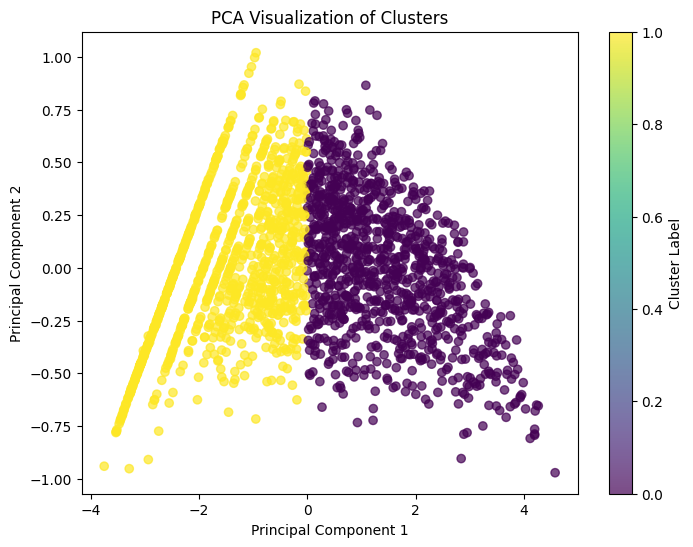

Explained Variance Ratio (PC1, PC2): [0.73045413 0.02866766]


In [82]:

reduced_data, var_ratio = visualize_clusters_with_pca(an_combined_matrix, an_labels, sample_frac=0.3)
print("Explained Variance Ratio (PC1, PC2):", var_ratio)


In [83]:
hybrid_recommender_kmeans(user_text = "vampire", top_movies = 5, top_anime= 5)

(array(['The Dead Undead', 'Bled', 'Like Crazy', 'Alien Zone',
        'The Mighty'], dtype=object),
 array(['Chikyuu to no Yakusoku', 'Watashitachi no Mirai', 'Ongeki',
        'Gum Shaara', 'A Tang Qi Yu'], dtype=object))